In [1]:
from matplotlib import style
style.use('fivethirtyeight')
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
import scipy.stats as st

In [3]:
from sqlalchemy import create_engine, Column, Integer, String, Float, Date, func
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker

In [4]:
# Create engine
engine = create_engine("sqlite:///campaign_data.sqlite")

In [5]:
# Declare a Base using declarative_base()
Base = declarative_base()

/var/folders/7b/trlfgd_d5gv_jv53bccbf7rw0000gn/T/ipykernel_68165/3100029033.py:2: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


In [6]:
# Define the Campaign class
class Campaign(Base):
    __tablename__ = 'campaign'
    id = Column(Integer, primary_key=True)  
    cf_id = Column(Integer)
    contact_id = Column(Integer)
    company_name = Column(String)
    description = Column(String)
    goal = Column(Float)
    pledged = Column(Float)
    outcome = Column(String)
    backers_count = Column(Integer)
    country = Column(String)
    currency = Column(String)
    launch_date = Column(Date)
    end_date = Column(Date)
    category_id = Column(Integer)
    subcategory_id = Column(Integer)

In [7]:
Base.metadata.create_all(engine)

In [8]:
# Create a session
Session = sessionmaker(bind=engine)
session = Session()

In [9]:
# Query for the data needed for the bar chart, excluding 'live' outcomes
query = session.query(Campaign.outcome, func.count(Campaign.outcome)).filter(Campaign.outcome != 'live').group_by(Campaign.outcome)
result = query.all()

# Convert the results to a DataFrame
df_outcome = pd.DataFrame(result, columns=['outcome', 'frequency'])
df_outcome

,outcome,frequency
0,canceled,57
1,failed,364
2,successful,565


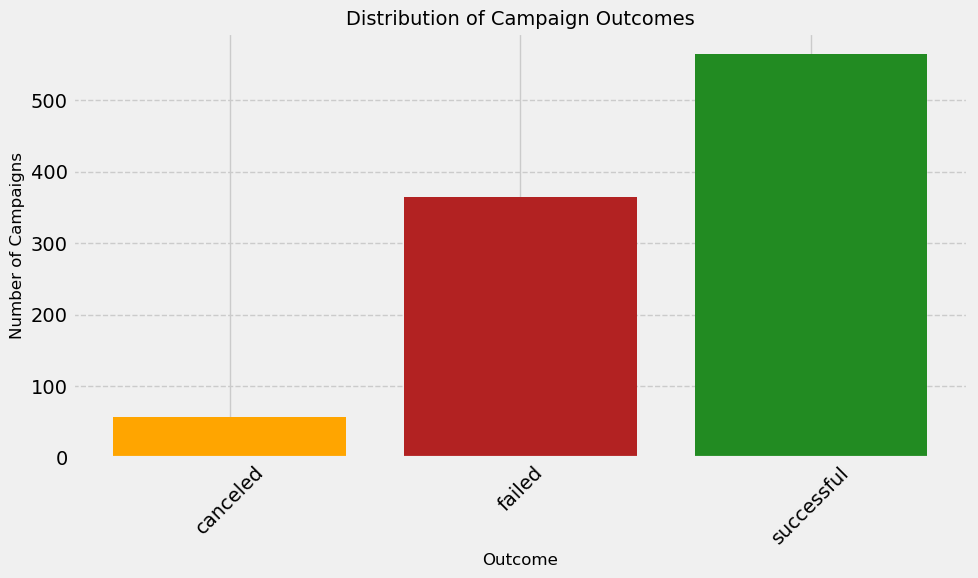

In [10]:
# Plot Bar Chart
# Define colors for each outcome
colors = {
    'canceled': 'orange',
    'failed': 'firebrick',
    'successful': 'forestgreen'
}

# Create the bar chart with custom colors
plt.figure(figsize=(10, 6))  
plt.bar(
    df_outcome['outcome'],
    df_outcome['frequency'],
    color=[colors[outcome] for outcome in df_outcome['outcome']]
)

# Add labels and title (the rest of your code stays the same)
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Number of Campaigns', fontsize=12)
plt.title('Distribution of Campaign Outcomes', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

In [11]:
with Session(bind=engine) as session:  
    country_pledged_data = (
        session.query(Campaign.country, func.sum(Campaign.pledged).label('total_pledged'))
        .group_by(Campaign.country)
        .all()
    )

# Create DataFrame (if needed)
df_pledged = pd.DataFrame(country_pledged_data, columns=['country', 'total_pledged'])
df_pledged

,country,total_pledged
0,AU,2114541.0
1,CA,2812788.0
2,CH,891415.0
3,DK,1129068.0
4,GB,2192705.0
5,IT,2198202.0
6,US,31409336.0


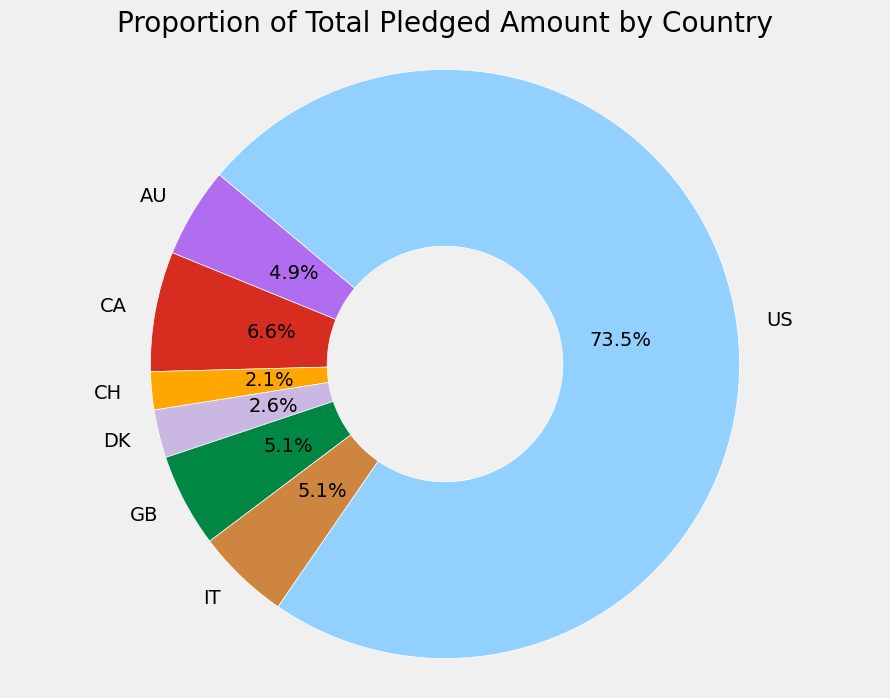

In [12]:
# Create Pie Chart
# Ensure each country has a unique color
colors = {
    'US': '#92d0ff',           # USA: Navy blue
    'GB': '#008744',    # Great Britain: Forest green (like the Union Jack)
    'CA': '#d62d20',           # Canada: Red (like the maple leaf)
    'AU': '#b06df0',  # Australia: Dark goldenrod (outback)
    'DK': '#cab7e2',      # Denmark: Firebrick (Danish flag)
    'IT': 'peru',           # Italy: Peru (like the earth tones of Italy)
    'CH': '#ffa700',        # Switzerland: Dark red (Swiss flag)
}

# Create an array of colors based on the countries in your DataFrame
country_colors = [colors.get(country, 'gray') for country in df_pledged['country']]

# Create the pie chart
plt.figure(figsize=(10, 8))
plt.pie(
    df_pledged['total_pledged'],
    labels=df_pledged['country'],
    autopct='%1.1f%%',
    startangle=140,
    colors=country_colors,  
    wedgeprops=dict(width=0.6, edgecolor='w') 
)
plt.title('Proportion of Total Pledged Amount by Country')
plt.axis('equal')
plt.show()

In [13]:
# Query for the data needed for the scatter plot
with Session(bind=engine) as session:
    query = session.query(Campaign.goal, Campaign.pledged).all()

# Convert the results to a DataFrame
df_pledge = pd.DataFrame(query, columns=['goal', 'pledged'])
df_pledge

,goal,pledged
0,100.0,0.0
1,1400.0,14560.0
2,108400.0,142523.0
3,4200.0,2477.0
4,7600.0,5265.0
...,...,...
995,97300.0,153216.0
996,6600.0,4814.0
997,7600.0,4603.0
998,66600.0,37823.0


/opt/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


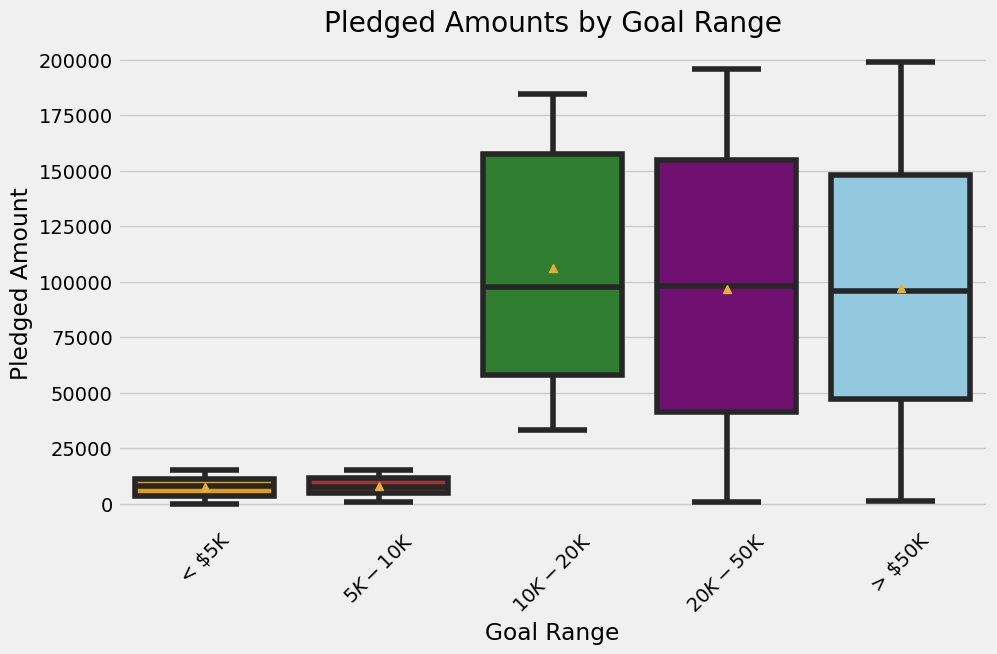

In [14]:
# Categorize funding goals into ranges
df_pledge['goal_range'] = pd.cut(df_pledge['goal'], 
                                 bins=[0, 5000, 10000, 20000, 50000, np.inf],
                                 labels=['< $5K', '$5K-$10K', '$10K-$20K', '$20K-$50K', '> $50K'])

# Set up figure
plt.figure(figsize=(10, 6))  # Create a 10x6 inch figure

# Define a custom color palette for the boxplots
colors = ["orange", "firebrick", "forestgreen", "purple", "skyblue"]

# Create the boxplot with the custom colors and show the mean values
sns.boxplot(x='goal_range',            # X-axis: Goal ranges
            y='pledged',              # Y-axis: Pledged amounts
            data=df_pledge,           # Data source
            showmeans=True,           # Display the mean values
            palette=colors)           # Use the custom color palette

# Add labels and title
plt.title('Pledged Amounts by Goal Range')
plt.xlabel('Goal Range')
plt.ylabel('Pledged Amount')
plt.xticks(rotation=45)      # Rotate x-axis labels for better readability

# Display the plot
plt.show()

In [15]:
# Query for the data needed for the scatter plot
with Session(bind=engine) as session:
    query = session.query(Campaign.goal, Campaign.pledged, Campaign.outcome).all()

# Convert the results to a DataFrame named df_scatter
df_scatter = pd.DataFrame(query, columns=['goal', 'pledged', 'outcome'])
df_scatter.head()

,goal,pledged,outcome
0,100.0,0.0,failed
1,1400.0,14560.0,successful
2,108400.0,142523.0,successful
3,4200.0,2477.0,failed
4,7600.0,5265.0,failed


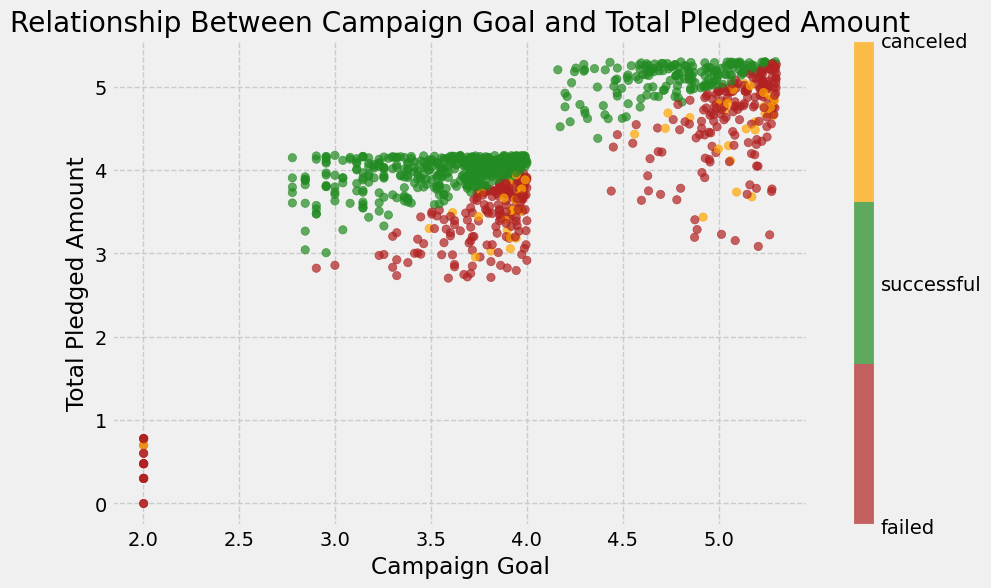

In [16]:
# Create log columns for visualization (adding 1 to prevent log(0) errors)
df_scatter['log_goal'] = np.log10(df_scatter['goal'] + 1)  
df_scatter['log_pledged'] = np.log10(df_scatter['pledged'] + 1)

# Assign numerical values to each outcome for color mapping
outcome_mapping = {'failed': 0, 'successful': 1, 'canceled': 2}
df_scatter['outcome_numeric'] = df_scatter['outcome'].map(outcome_mapping)

# Define custom colors for each outcome
cmap = ListedColormap(['firebrick', 'forestgreen', 'orange'])  # Colors for failed, successful, canceled

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_scatter['log_goal'], df_scatter['log_pledged'], c=df_scatter['outcome_numeric'], cmap=cmap, alpha=0.7)
plt.title('Relationship Between Campaign Goal and Total Pledged Amount')
plt.xlabel('Campaign Goal')
plt.ylabel('Total Pledged Amount')

# Add a legend
cbar = plt.colorbar(scatter)
cbar.set_ticks([0, 1, 2])  # Position ticks in the middle of each color
cbar.set_ticklabels(list(outcome_mapping.keys()))  # Label the ticks with outcome names

plt.grid(axis='both', linestyle='--')
plt.show()

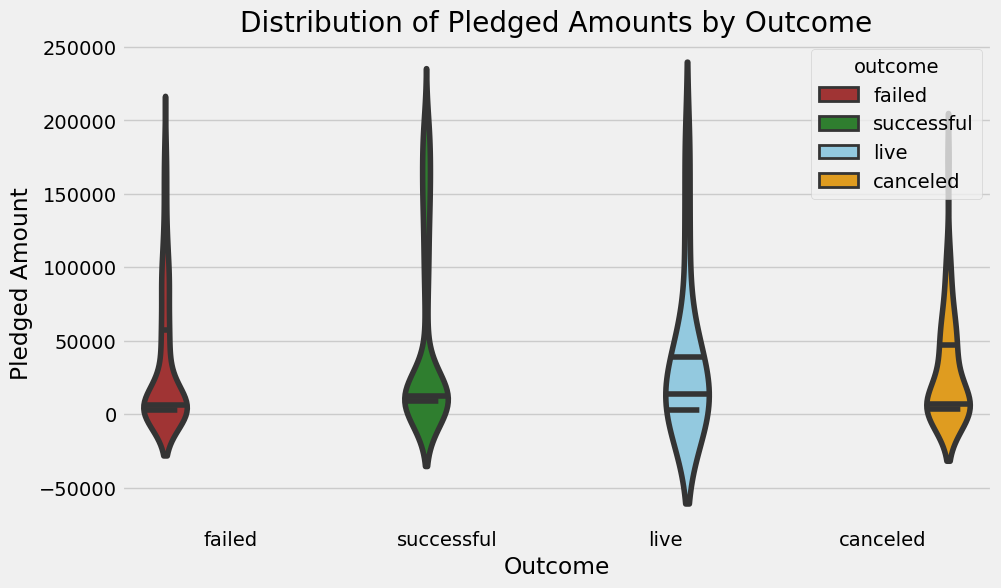

In [17]:
# Get unique outcome values and define colors
outcomes = df_scatter['outcome'].unique()  # Get all unique outcomes
colors = {
    'canceled': 'orange',
    'failed': 'firebrick',
    'successful': 'forestgreen',
}
for outcome in outcomes:
    if outcome not in colors:
        colors[outcome] = 'skyblue'  # Assign blue to any other outcome, including 'live'

# Create a violin plot using Seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(x='outcome', y='pledged', data=df_scatter, hue='outcome', palette=colors, inner='quartile')

plt.title('Distribution of Pledged Amounts by Outcome')
plt.xlabel('Outcome')
plt.ylabel('Pledged Amount')

plt.show()

In [18]:
df_plot = pd.read_sql_query(
    session.query(Campaign.goal, Campaign.backers_count)
    .filter(Campaign.outcome != "live")  # Exclude live campaigns
    .statement,
    session.bind,
)
df_plot

,goal,backers_count
0,100.0,0
1,1400.0,158
2,108400.0,1425
3,4200.0,24
4,7600.0,53
...,...,...
981,97300.0,2043
982,6600.0,112
983,7600.0,139
984,66600.0,374


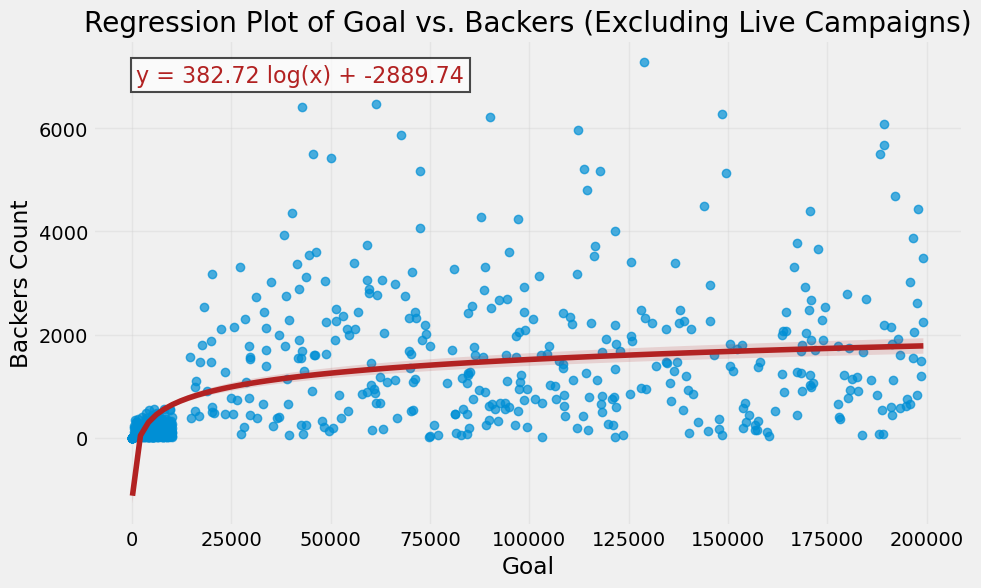

In [19]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(
    x="goal", 
    y="backers_count", 
    data=df_plot, 
    logx=True, 
    scatter_kws={'alpha':0.7},
    line_kws={'color': 'firebrick', "linewidth": 4}  
)

# Calculate and display regression equation
slope, intercept, r_value, p_value, std_err = st.linregress(np.log(df_plot["goal"]), df_plot["backers_count"])
equation = f"y = {slope:.2f} log(x) + {intercept:.2f}"

# Set annotation position (adjust as needed)
x_pos = 0.05  # Fraction of the plot width
y_pos = 0.95  # Fraction of the plot height

# Add the equation annotation
ax.text(
    x_pos, 
    y_pos, 
    equation, 
    transform=ax.transAxes, 
    fontsize=16, 
    verticalalignment='top', 
    bbox=dict(
        facecolor='white', 
        alpha=0.7, 
        edgecolor='black',
        linewidth=1.5          # Set border width
    ),
    color='firebrick'           # Set font color to firebrick
)

plt.xlabel("Goal")
plt.ylabel("Backers Count")
plt.title("Regression Plot of Goal vs. Backers (Excluding Live Campaigns)")
plt.grid(axis="both", alpha=0.3)
plt.show()